# Crawler

## Import the necessary libs

In [ ]:
import os
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin

## Global variables

In [ ]:
# Create corpus path
folder_path = os.path.join("./corpus")
os.makedirs(folder_path, exist_ok=True)

# Base link
base_link = "https://www.voanews.com"

## Crawler Class

In [ ]:
class my_crawler():
    def __init__(self, start_link, keyword):
        self.link_to_explore = start_link
        self.keyword = keyword
        self.url_prefix, self.url_suffix = start_link.split("pi=1")
        self.articles = pd.DataFrame(columns = ['keyword', 'article'])
        self.pagecount = 1
        self.next = True
        self.hrefs = set()

    def run(self):
        while self.next:
            if self.pagecount > 2:
                self.extract_data_at_once()
                self.save_data_to_file()
                self.next = False
            try:
                self.get_urls()
                self.pagecount = self.pagecount + 1
            except:
                print ("Cannot get the page " + self.link_to_explore)
                self.next = False
                raise

    def get_urls(self):

        # Regex Match
        self.link_to_explore = self.url_prefix + "pi=" + str(self.pagecount) + self.url_suffix

        # Send requests
        response = requests.get(self.link_to_explore)
        html_content = response.content

        # Parse the html contents
        soup = BeautifulSoup(html_content, "html.parser")

        container = soup.find(class_="media-block-wrap")

        # Get all the hrefs (repetition included)
        if container:
            links = container.find_all("a")
            links_exclude = container.find_all("a", class_ = "links__item-link")
            links = list(set(links) - set(links_exclude))
        else:
            print("Container not found!")
            return

        for link in links:
            href = link.get("href")
            self.hrefs.add(href)

    def extract_data_at_once(self):

        for idx, half_link in enumerate(self.hrefs):
            full_link = urljoin(base_link, half_link)

            try:
                response = requests.get(full_link)
                response.raise_for_status()  # Check the abnormal code
                html = BeautifulSoup(response.content, "html.parser")
                # articles = html.find_all(class_="RichTextStoryBody RichTextBody")
                articles = html.find_all("p")
                if articles is None:
                    continue

                # Get the content of the article
                content = ' '.join([article.get_text() for article in articles[1:]])

                # Control the frequency of the requests
                time_between_requests = 6 / 3  # 2 RPM
                time.sleep(time_between_requests)

                # Write down the articles
                self.articles.loc[len(self.articles)] = [self.keyword, content]

                if len(self.articles) % 10 == 0:
                    print("Finish loading", len(self.articles), "aricles...")


            except requests.RequestException as e:
                print(f"WRONG REQUEST{str(e)}")

    def save_data_to_file(self):
        self.articles.to_csv ('./corpus/%s_dataset.csv' % self.keyword, index = None, header=True, encoding='utf_8_sig')

## Merge the datasets of different topics

In [ ]:
def merge_files():

    SaveFile_Path = r"./corpus"
    SaveFile_Name = r"dataset.csv"

    # Save all the file to a list
    file_list = os.listdir(folder_path)

    # Read the first file (header = True)
    df = pd.read_csv(folder_path + "\\" + file_list[0])

    # Save the first file to the merged file
    df.to_csv(SaveFile_Path + "\\" + SaveFile_Name, encoding="utf_8_sig", index=False)

    # Traverse the files and merge the rest of the files
    for i in range(1, len(file_list)):
        df = pd.read_csv(folder_path + "\\" + file_list[i])
        df.to_csv(
            SaveFile_Path + "\\" + SaveFile_Name,
            encoding="utf_8_sig",
            index=False,
            header=False,
            mode="a+",
        )

## Start Crawling

In [ ]:

# Six different topics/keywords
keywords = ['medical', 'technology', 'entertainment', 'sports', 'environment', 'politics']
for keyword in keywords:
    url_start = "https://www.voanews.com/s?k=%s&tab=all&pi=1&r=any&pp=20" % keyword
    try:
        mycrawler = my_crawler(url_start, keyword)
        mycrawler.run()
        print("Finished loading all the articles from topic: %s !" % keyword)
    except:
        raise
# Merge the csv datasets
merge_files()


Finish loading 10 aricles...
Finish loading 20 aricles...
Finish loading 30 aricles...
Finish loading 40 aricles...
Finished loading all the articles from topic: medical !
Finish loading 10 aricles...
Finish loading 20 aricles...
Finish loading 30 aricles...
Finish loading 40 aricles...
Finished loading all the articles from topic: technology !
Finish loading 10 aricles...
Finish loading 20 aricles...
Finish loading 30 aricles...
Finish loading 40 aricles...
Finished loading all the articles from topic: entertainment !
Finish loading 10 aricles...
Finish loading 20 aricles...
Finish loading 30 aricles...
Finish loading 40 aricles...
Finished loading all the articles from topic: sports !
Finish loading 10 aricles...
Finish loading 20 aricles...
Finish loading 30 aricles...
Finish loading 40 aricles...
Finished loading all the articles from topic: environment !
Finish loading 10 aricles...
Finish loading 20 aricles...
Finish loading 30 aricles...
Finish loading 40 aricles...
Finished loa

# Data Clean & Visualization

## Import libs

In [ ]:
import nltk
import re
import csv
import string
from nltk.corpus import stopwords
from textblob import TextBlob

## Download necessary files

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhuwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhuwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhuwe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Function definition

In [ ]:
def clean_text(text):
    # Eliminate HTML lables and entities
    text = re.sub(r"<.*?>", "", text)
    # Subtract punctuations, including unicode characters
    # Create a translation table
    translator = str.maketrans(
        {
            "\u2018": "",
            "\u2019": "",  # Single quotes
            "\u201c": "",
            "\u201d": "",  # Double quotes
            "\u2026": "",
            "\u2013": "",
            "\u2014": "",  # Ellipsis and dashes
        }
    )
    translator.update(str.maketrans("", "", string.punctuation))
    text = text.translate(translator)
    # Lowercasing
    text = text.lower()

    # Subtract stop words
    stop_words = stopwords.words("english")
    stop_words.extend(
        [
            "from",
            "said",
            "say",
            "reported",
            "news",
            "according",
            "would",
            "could",
            "posting",
            "article",
            "one",
            "two",
            "three",
        ]
    )
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Correct possible spelling errors
    text = str(TextBlob(text).correct())

    # Detele extra white spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


## Save the clean data

In [ ]:
# Read the data
with open("./corpus/dataset.csv", 'r', encoding='utf_8_sig') as f:
    reader = csv.reader(f)
    data = list(reader)

# Create a new list storing the cleaned data
cleaned_data = ['clean_data']
for idx, text in enumerate(data[1:]):
    cleaned_data.append(clean_text(text[1]))
    if (idx + 1) % 20 == 0:
        print("Finished cleaning", idx+1, "articles!")

# Merge the columns
for idx, row in enumerate(data):
    row.append(cleaned_data[idx])
data = pd.DataFrame(data)

# Save the data
data.to_csv('./corpus/dataset.csv',index=False,mode='w',header=None, encoding='utf_8_sig')


Finished cleaning 20 articles!
Finished cleaning 40 articles!
Finished cleaning 60 articles!
Finished cleaning 80 articles!
Finished cleaning 100 articles!
Finished cleaning 120 articles!
Finished cleaning 140 articles!
Finished cleaning 160 articles!
Finished cleaning 180 articles!
Finished cleaning 200 articles!
Finished cleaning 220 articles!
Finished cleaning 240 articles!


## Visualization

### Import libs

In [ ]:
from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import ngrams

### Function definition

In [ ]:
# Tokenize the text
def tokenize(text):
    return word_tokenize(text)

# Word Frequency Analysis: Identify the most frequent words.
def word_frequency(tokens):
    return Counter(tokens)

# N-gram Analysis: Explore common bigrams, trigrams, etc.
def ngram_analysis(tokens, n=2):
    return list(ngrams(tokens, n))

# Visualization: Use word clouds for visual analysis.
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def lemmatize_sentence_textblob(sentence):
    blob = TextBlob(sentence)
    lemmatized_sentence = [word.lemmatize() for word in blob.words]
    return ' '.join(lemmatized_sentence)

def draw_from_dict(dicdata,RANGE, heng=0):
    # dicdata： data from the dict
    # RANGE： range of the dict that is going to show
    # heng=0 : vertical bars; heng=1 : horizon bars
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return
    else:
        return "heng has to be 0 or 1!!"

         keyword                                            article  \
0  entertainment  He surveyed the Arizona crowd that had paid to...   
1  entertainment  \n\n\nPrint\n\n Every four summers in America ...   
2  entertainment  U.S. President Joe Biden said Saturday that he...   
3  entertainment  Barack Obama, Bill Clinton and some big names ...   
4  entertainment  After more than 40 years, Macao’s horse track ...   

                                          clean_data  
0  surveyed arizona crowd paid catch wresting gli...  
1  print every four summer america comes spectacl...  
2  us president joe widen saturday regretted usin...  
3  back drama bill clinton big names entertainmen...  
4  40 years matas horse track posted final races ...  
Counter({'people': 498, 'us': 427, 'also': 397, 'new': 300, 'china': 300, 'president': 274, 'like': 271, 'years': 253, 'million': 243, 'first': 231, 'government': 221, 'year': 220, 'state': 215, 'vol': 209, 'ai': 208, 'last': 206, 'told': 203,

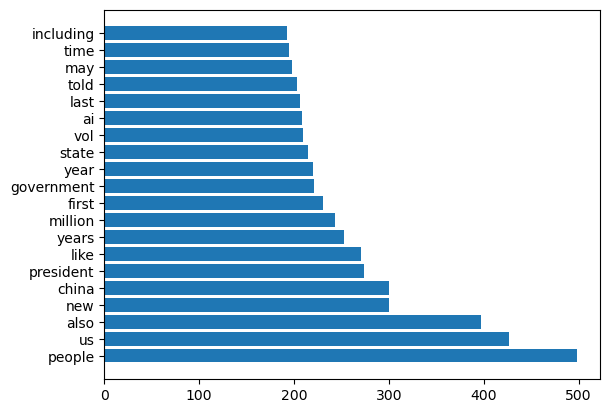

Counter({'united states': 100, 'told vol': 96, 'amy heap': 68, 'last year': 65, 'white house': 58, 'prime minister': 57, 'new york': 57, 'swim coach': 57, 'heap swim': 55, 'joe widen': 53, 'social media': 49, 'million people': 46, 'president joe': 44, 'open water': 41, 'south africa': 40, 'last week': 38, 'associated press': 37, 'cuba diving': 34, 'united nations': 30, 'human rights': 29, 'artificial intelligence': 29, 'south more': 29, 'south organ': 28, 'voice america': 27, 'donald tramp': 26, 'former president': 26, 'around world': 26, 'vol journalists': 26, 'journalists may': 26, 'can not': 26, 'climate change': 26, 'america provides': 25, 'provides information': 25, 'information 40': 25, '40 languages': 25, 'languages estimated': 25, 'estimated weekly': 25, 'weekly audience': 25, 'audience 326': 25, '326 million': 25, 'people stories': 25, 'stories vol': 25, 'vol line': 25, 'line work': 25, 'work multiple': 25, 'multiple vol': 25, 'may contain': 25, 'contain information': 25, 'inf

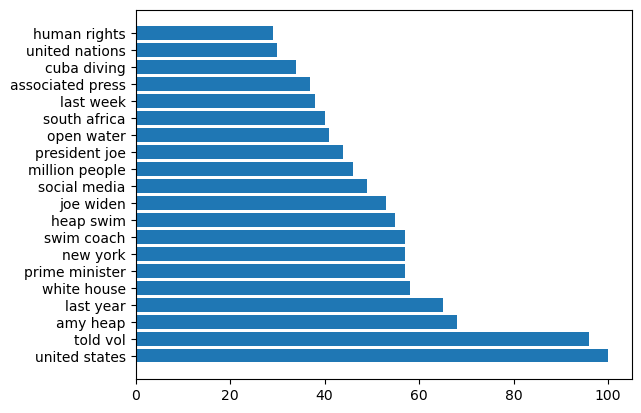

Word Cloud for clean data before lemmatize: 


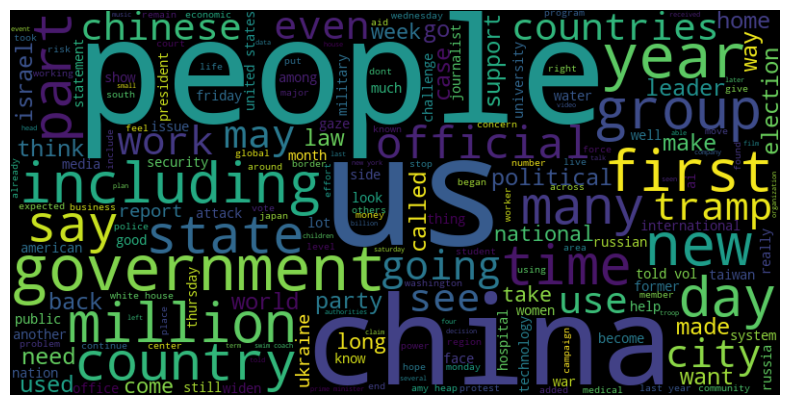

Counter({'people': 517, 'year': 473, 'u': 427, 'also': 397, 'state': 360, 'country': 321, 'new': 300, 'china': 300, 'president': 294, 'like': 277, 'million': 273, 'government': 260, 'first': 231, 'world': 225, 'time': 225, 'party': 217, 'group': 212, 'vol': 209, 'ai': 208, 'last': 206, 'told': 203, 'water': 201, 'may': 198, 'work': 196, 'including': 193, 'get': 191, 'south': 191, 'day': 190, 'week': 190, 'city': 188, 'since': 188, 'medium': 188, 'report': 187, 'tramp': 183, 'israel': 181, 'part': 177, 'widen': 172, 'journalist': 170, 'woman': 170, 'many': 169, 'chinese': 169, 'voice': 168, 'official': 162, 'security': 161, 'law': 160, 'make': 159, 'say': 157, 'back': 154, 'international': 153, 'going': 152, 'see': 152, 'around': 148, 'military': 148, 'united': 147, 'want': 145, 'even': 145, 'election': 145, 'political': 143, 'russian': 143, 'service': 143, 'go': 142, 'nation': 142, 'right': 142, 'national': 141, 'need': 138, 'company': 137, 'think': 137, 'leader': 137, 'made': 137, 'ta

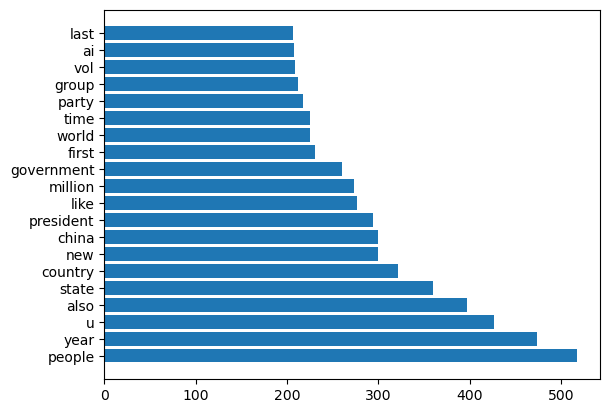

Counter({'united state': 100, 'told vol': 96, 'last year': 74, 'amy heap': 70, 'white house': 61, 'prime minister': 60, 'new york': 57, 'swim coach': 57, 'heap swim': 55, 'joe widen': 53, 'million people': 53, 'social medium': 49, 'president joe': 44, 'last week': 42, 'open water': 42, 'south africa': 40, 'wire service': 39, 'associated press': 37, 'cuba diving': 34, 'united nation': 30, 'former president': 29, 'human right': 29, 'artificial intelligence': 29, 'south more': 29, 'south organ': 28, 'year ago': 27, 'voice america': 27, 'donald tramp': 26, 'around world': 26, 'line work': 26, 'vol journalist': 26, 'journalist may': 26, 'can not': 26, 'climate change': 26, 'south african': 26, 'attorney general': 25, 'america provides': 25, 'provides information': 25, 'information 40': 25, '40 language': 25, 'language estimated': 25, 'estimated weekly': 25, 'weekly audience': 25, 'audience 326': 25, '326 million': 25, 'people story': 25, 'story vol': 25, 'vol line': 25, 'work multiple': 25,

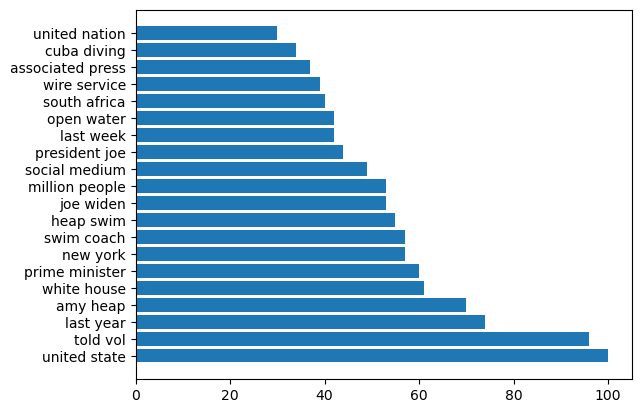

Word Cloud for clean data after lemmatize: 


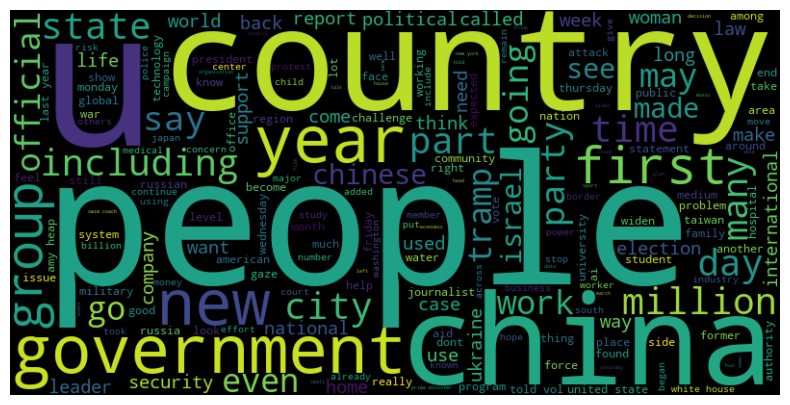

In [ ]:
# Read the data
df = pd.read_csv('./corpus/dataset.csv', encoding='utf_8')
print(df.head())
# Merge all the articles into one string
long_string = ' '.join(article for article in df['clean_data'].values)
lemmatized_long_string = lemmatize_sentence_textblob(long_string)

# The visualization before lemmatize

# Single word frequency
word_freq = word_frequency(tokenize(long_string))
print(word_freq)
draw_from_dict(dict(word_freq), 20, heng=1)

# Bi-grams frequency
ngram_ana = ngram_analysis(tokenize(long_string))
bi_grams = []
for item in ngram_ana:
    a = ' '.join(word for word in list(item))
    bi_grams.append(a)
bi_word_freq = word_frequency(bi_grams)
print(bi_word_freq)
draw_from_dict(dict(bi_word_freq), 20, heng=1)
print("Word Cloud for clean data before lemmatize: ")
plot_wordcloud(long_string)

# The visualization after lemmatize

# Single word frequency
lemmatized_word_freq = word_frequency(tokenize(lemmatized_long_string))
print(lemmatized_word_freq)
draw_from_dict(dict(lemmatized_word_freq), 20, heng=1)

# Bi-grams frequency
lemmatized_ngram_ana = ngram_analysis(tokenize(lemmatized_long_string))
lemmatized_bi_grams = []
for item in lemmatized_ngram_ana:
    a = ' '.join(word for word in list(item))
    lemmatized_bi_grams.append(a)
lemmatized_bi_word_freq = word_frequency(lemmatized_bi_grams)
print(lemmatized_bi_word_freq)
draw_from_dict(dict(lemmatized_bi_word_freq), 20, heng=1)
print("Word Cloud for clean data after lemmatize: ")
plot_wordcloud(lemmatized_long_string)


## Feature Extraction

### Import libs

In [ ]:
from gensim.models import Word2Vec
import numpy as np

### Word2Vec features

In [ ]:
# We leverage pre-trained model word2vec to generate features
def word2vec_embedding(tokens):
    # Parameters:
    # - sg: 1 for skip-gram; 0 for CBOW, default = 0
    # - vector_size: dimensions of the word vectors
    # - window: context window size
    # - min_count: minimum frequency of words to consider
    model = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4)
    return model

word_emb = word2vec_embedding([tokenize(article) for article in list(df['clean_data'].values)])


In [ ]:
print(f"Vocabulary size: {len(word_emb.wv.key_to_index)}")

Vocabulary size: 13268


### Generate article vectors

In [ ]:
def get_article_vector(article, model):
    words = tokenize(article)
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
        else:
            print(word, "isn't in the vocabulary!")

    if word_vectors:
        article_vector = np.mean(word_vectors, axis=0)
    else:
        # Handle case where no words in sentence are in the vocabulary
        article_vector = np.zeros(model.vector_size)
    return article_vector

# Generate vectors for the entire corpus
article_vectors = [get_article_vector(article, word_emb) for article in list(df['clean_data'].values)]

print("Article vectors:")
for vec in article_vectors:
    print(vec)


Article vectors:
[-0.07869698  0.17923494  0.06806624  0.01932973  0.01016257 -0.2788038
  0.04488046  0.34748662 -0.12634592 -0.1486494  -0.04810203 -0.23551318
 -0.06426853  0.06758628  0.07170351 -0.07209793  0.00114421 -0.21066546
  0.01536123 -0.23134723  0.10415156  0.07186539  0.12354052 -0.01217597
  0.01238485 -0.03492412 -0.08335271 -0.02040213 -0.16617414  0.00837087
  0.20163338 -0.02158696 -0.03115286 -0.07140432  0.05039002  0.10800196
  0.07080735 -0.1444917  -0.10793023 -0.28994453  0.07110366 -0.11586914
 -0.11967747 -0.04761669  0.14950803 -0.11747441 -0.13037229  0.00065379
 -0.0063071   0.12400826  0.02715089 -0.12298244 -0.15192759 -0.09717347
 -0.12145482  0.10090335  0.04849686 -0.00049866 -0.12601839  0.03345027
  0.03486011  0.09236144 -0.04883837  0.02392927 -0.1615587   0.06163342
  0.04114299  0.10593612 -0.1589278   0.13532749 -0.11014607  0.09478255
  0.21939886 -0.10969664  0.15121658  0.02831597  0.00204926 -0.01178273
 -0.16727175  0.08388223  0.0142784

## Model Training & Evaluating

### Import libs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cv :  KFold(n_splits=5, random_state=3, shuffle=True)
error_score :  nan
estimator__memory :  None
estimator__steps :  [('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis())]
estimator__verbose :  False
estimator__scaler :  StandardScaler()
estimator__lda :  LinearDiscriminantAnalysis()
estimator__scaler__copy :  True
estimator__scaler__with_mean :  True
estimator__scaler__with_std :  True
estimator__lda__covariance_estimator :  None
estimator__lda__n_components :  None
estimator__lda__priors :  None
estimator__lda__shrinkage :  None
estimator__lda__solver :  svd
estimator__lda__store_covariance :  False
estimator__lda__tol :  0.0001
estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis())])
n_jobs :  -1
param_grid :  {'scaler': [StandardScaler(), MinMaxScaler()], 'lda__solver': ['svd', 'lsqr', 'eigen'], 'lda__tol': [0.0001, 0.001, 0.01], 'lda__store_covariance': [True, False]}
pre_dispatch :  2*n_jobs
refit :  True


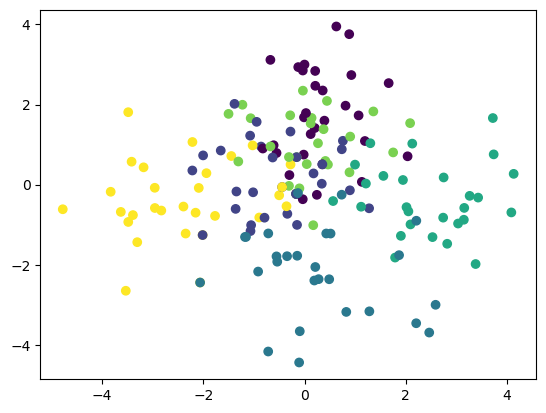

{'entertainment': {'precision': 0.23076923076923078, 'recall': 0.25, 'f1-score': 0.24, 'support': 12.0}, 'environment': {'precision': 0.3333333333333333, 'recall': 0.3333333333333333, 'f1-score': 0.3333333333333333, 'support': 15.0}, 'medical': {'precision': 0.3888888888888889, 'recall': 0.7, 'f1-score': 0.5, 'support': 10.0}, 'politics': {'precision': 0.125, 'recall': 0.1, 'f1-score': 0.1111111111111111, 'support': 10.0}, 'sports': {'precision': 0.4444444444444444, 'recall': 0.3076923076923077, 'f1-score': 0.36363636363636365, 'support': 13.0}, 'technology': {'precision': 0.3333333333333333, 'recall': 0.25, 'f1-score': 0.2857142857142857, 'support': 12.0}, 'accuracy': 0.3194444444444444, 'macro avg': {'precision': 0.30929487179487175, 'recall': 0.3235042735042735, 'f1-score': 0.30563251563251564, 'support': 72.0}, 'weighted avg': {'precision': 0.3150819088319088, 'recall': 0.3194444444444444, 'f1-score': 0.30759660092993424, 'support': 72.0}}


In [ ]:
# Example labels for a classification task
labels = list(df["keyword"].values)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    article_vectors, labels, test_size=0.3, random_state=3
)

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Normalize the data
        ("lda", LinearDiscriminantAnalysis()),  # LDA model
    ]
)

# Grid search
param_grid = {
    "scaler": [StandardScaler(), MinMaxScaler()],
    "lda__solver": ["svd", "lsqr", "eigen"],
    "lda__tol": [1e-4, 1e-3, 1e-2],
    "lda__store_covariance": [True, False],
}

# K-fold
# n_splits: Number of folds. Must be at least 2.
# shuffle: if shuffle the dataset
# random_state: When shuffle is True, random_state controls the randomness of each fold.
kfold = KFold(n_splits=5, shuffle=True, random_state=3)

grid_search = GridSearchCV(
    pipeline, param_grid, cv=kfold, scoring="accuracy", n_jobs=-1
)

# Train a classifier
grid_search.fit(X_train, y_train)
for k, v in grid_search.get_params().items():
    print(k, ": ", v)

# best_model = grid_search.best_estimator_
# print(f"Best Model: {best_model}")

# Convert labels to numbers to visualize
labels_to_numbers = []
for idx, item in enumerate(y_train):
    if item == "medical":
        labels_to_numbers.append(0)
    elif item == "technology":
        labels_to_numbers.append(1)
    elif item == "entertainment":
        labels_to_numbers.append(2)
    elif item == "sports":
        labels_to_numbers.append(3)
    elif item == "environment":
        labels_to_numbers.append(4)
    elif item == "politics":
        labels_to_numbers.append(5)
    else:
        continue

# Visualize the distribution of labels
x_new = grid_search.transform(X_train)
plt.scatter(x_new[:, 0], x_new[:, 1], marker="o", c=labels_to_numbers)
plt.show()

# Predict and evaluate
y_pred = grid_search.predict(X_test)
cl_re = classification_report(
    y_test, y_pred, output_dict=True
)
print(cl_re)


### Visualize the results

In [ ]:
import seaborn as sns

<Axes: >

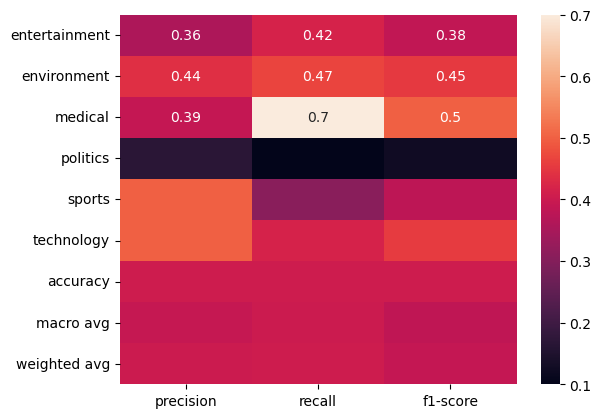

In [ ]:
sns.heatmap(pd.DataFrame(cl_re).iloc[:-1, :].T, annot=True)


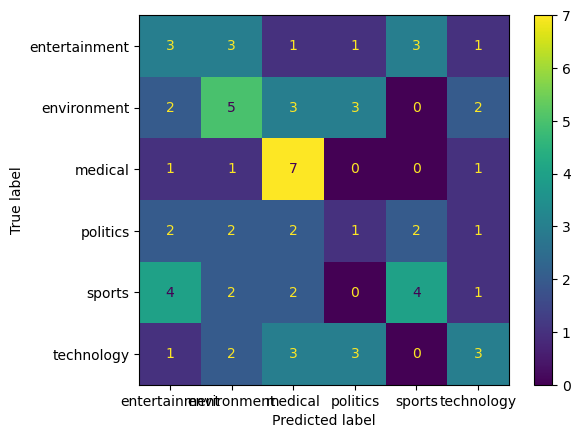

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['entertainment', 'environment', 'medical', 'politics', 'sports', 'technology'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['entertainment', 'environment', 'medical', 'politics', 'sports', 'technology'])
disp.plot()
plt.show()
